In [ ]:
# Street length visualization data processing

The number of addresses associated with a certain street is a distinguishable concept from that of the actual length of that street.

I wanted to construct a visualization of street length by plotting streets' polylines on a map, using the public dataset of addresses in New York City. This requires the following steps:

1. Taking from the raw dataset a list of all validly-named streets in New York City.
2. Many streets are unique within a borough but not unique within the whole of New York. There are three Broadways, for instance. To handle this problem I need to cluster coordinates by the individual street that they are associated with.
3. I need to pass those coordinates to a line generation function.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns # hack---doing this sets the pandas plots to use seaborn styles!

In [4]:
%matplotlib inline

In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
pluto = pd.read_csv('nyc_pluto.csv', index_col=0)

/Users/Honors/anaconda/envs/nyc-buildings/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,20,22,23,24,25,66,67,82) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Extracting valid street names

The following code extracts a list of valid street names from the raw dataset.

1. Remove entries with missing addressal information or missing coordinates.
2. Discard addresses not containing at least one space character `' '`, signaling incompleteness.
3. Discard the address number at the beginning of the address, if it exists. The cases are:
  1. **Simple addresses**: `23 HANCOCK STREET`.
  2. **Lettered addresses**: `23A HANCOCK STREET`.
  3. **Compound addresses**: `23-42 HANCOCK STREET`.

In [1]:
def discard_address_number(address_string):
    split = address_string.split(' ')
    cand = split[0]
    if '-' in cand:
        cand = address_string.split('-')[0] # We may test one side and assume it is representative.
    try:
        int(cand)
        return ' '.join(split[1:])
    except:
        pass
    try:
        int(cand[:-1])
        return ' '.join(split[1:])
    except:
        pass
    return ' '.join(split[1:])

In [29]:
# Remove entries with missing addressal information or missing coordinates.
filtered_pluto = pluto[(pluto['Address'].notnull()) & (pluto['XCoord'].notnull()) & (pluto['YCoord'].notnull())]
# Discard addresses not containing at least one space character ' ', signaling incompleteness.
filtered_pluto = pluto[pluto['Address'].map(lambda x: ' ' in str(x))]
# Discard the address number at the beginning of the address, if it exists.
streets = filtered_pluto['Address'].map(discard_address_number)
filtered_pluto['Street'] = streets

/Users/Honors/anaconda/envs/nyc-buildings/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Clustering streets

After the previous step in this process we have `streets`, a set of every street name in New York City. However, street names are not unique except within a borough, so we have to apply a clustering algorithm to the streets to seperate them into seperate streets.

In [16]:
import mplleaflet
from pyproj import Proj
import matplotlib.pyplot as plt
import scipy
from sklearn.cluster import DBSCAN

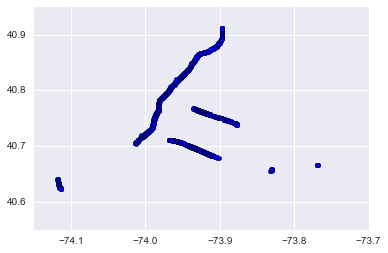

In [33]:
# Extract filled Broadway coordinates.
coords = filtered_pluto[filtered_pluto['Street'] == 'BROADWAY'][['XCoord', 'YCoord', 'Borough']]
coords = coords[(coords['Borough'] == 'Manhattan') | (coords['Borough'] == 'Bronx')]
coords = coords.dropna()
# Reproject from state grid to global coordinates.
projstr = '+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs'
pnyc = Proj(projstr,
            preserve_units=True)
coords = [pnyc(x, y, inverse=True) for x, y in zip(coords['XCoord'], coords['YCoord'])]

# Plot the resulting scatter.
plt.scatter([c[0] for c in coords], [c[1] for c in coords])
plt.figure(figsize=(24,10))
# mplleaflet.show()
plt.show()